In [0]:
import numpy as np
import warnings
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer

Read in the raw data and convert it to feature vectors.

In [26]:
data = []

with open('/content/cnnhealth.txt', 'rt') as cnnhealth:
  # only read the third column seperated by "|"
    for row in cnnhealth:
         row = row.split("|", 2)[2] 
         data.append(row)
cnnhealth.close()

warnings.filterwarnings("ignore")

vectorizer = CountVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(data)
x = X.toarray()
# print(vectorizer.get_feature_names())
# uncomment to generate the feature vectors text file
# np.savetxt("Feature_vectors.txt", bagArray, delimiter=",", fmt='%.0f')
unique, counts = np.unique(x, return_counts=True)
dict(zip(unique, counts))

{0: 44722994, 1: 47985, 2: 1500, 3: 42, 4: 4}

Two distance measures: Euclidean and Cosine

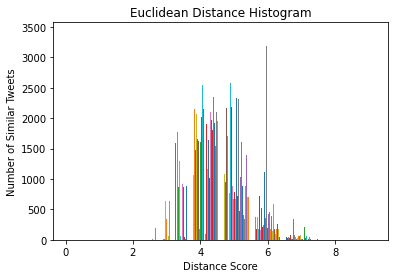

In [16]:
# Euclidean distance
euclidean_matrix = []
euclidean_matrix = euclidean_distances(x, x)
# uncomment to generate the text file of euclidean distacne matrix
# np.savetxt("Euclidean_distance.txt", euclidean_matrix, delimiter=",", fmt='%.2f')
plt.hist(euclidean_matrix)
plt.title('Euclidean Distance Histogram')
plt.xlabel('Distance Score')
plt.ylabel('Number of Similar Tweets')
plt.show()
# plt.savefig('Euclidean Distance Histogram.png')
# plt.close()


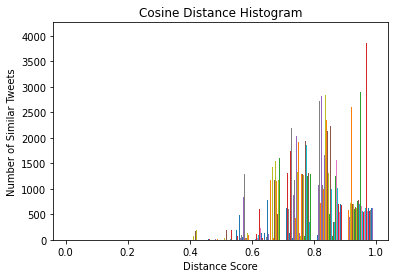

In [17]:
# Cosine distance
similarity = []
similarity = cosine_similarity(x, x)
similarity = np.around(similarity, decimals = 10)
cosine_matrix = []
cosine_matrix = np.array(1 - similarity)
# uncomment to generate the text file of euclidean distacne matrix
# np.savetxt("Cosine Distance Results.txt", cosine_matrix, delimiter=",", fmt='%.2f')
plt.hist(cosine_matrix)
plt.title('Cosine Distance Histogram')
plt.xlabel('Distance Score')
plt.ylabel('Number of Similar Tweets')
plt.show()
# plt.savefig('Cosine Distance Histogram.png')
# plt.close()

Agglomerative Clustering

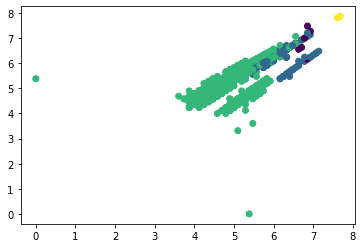

In [18]:
# Euclidean
euclidean_clustering = AgglomerativeClustering(n_clusters = 4, affinity='precomputed', linkage='complete')
euclidean_clustering = euclidean_clustering.fit(euclidean_matrix)
plt.scatter(euclidean_matrix[:,0], euclidean_matrix[:,1], c=euclidean_clustering.labels_)
# uncommet to save the figure
# plt.savefig('Euclidean cluster plot.png')
# plt.close()
plt.show()

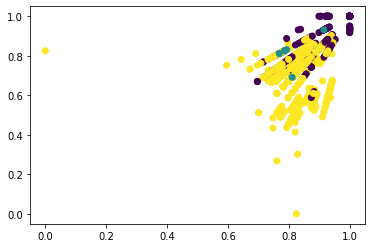

In [19]:
# Cosine clustering and plotting
cosine_clustering = AgglomerativeClustering(n_clusters = 3, affinity='precomputed', linkage='complete')
cosine_clustering = cosine_clustering.fit(cosine_matrix)
plt.scatter(cosine_matrix[:,0], cosine_matrix[:,1], c=cosine_clustering.labels_)
plt.show()
# uncommet to save the figure
# plt.savefig('Cosine cluster plot.png')
# plt.close()

Size distribution

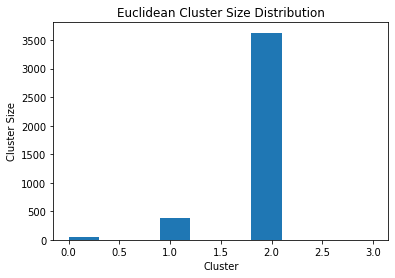

In [20]:
# cluster size distribution of euclidean
plt.hist(euclidean_clustering.labels_)
plt.title('Euclidean Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Cluster Size')
plt.show()
# plt.savefig('Euclidean cluster size distribution.png')
# plt.close()



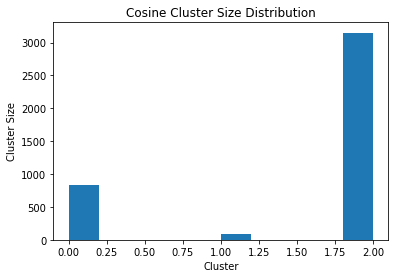

In [21]:
# cluster size distribution of cosine
plt.hist(cosine_clustering.labels_)
plt.title('Cosine Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Cluster Size')
plt.show()
# plt.savefig('Cosine cluster size distribution.png')
# plt.close()

Silhouette Score

In [22]:
print('Euclidean Silhouette Score: {}'.format(silhouette_score(euclidean_matrix, euclidean_clustering.labels_, 
                                           metric='euclidean')))

print('Cosine Silhouette Score: {}'.format(silhouette_score(cosine_matrix, cosine_clustering.labels_, 
                                           metric='cosine')))


Euclidean Silhouette Score: 0.44564001473839565
Cosine Silhouette Score: 0.05381258699106858


Heatmap

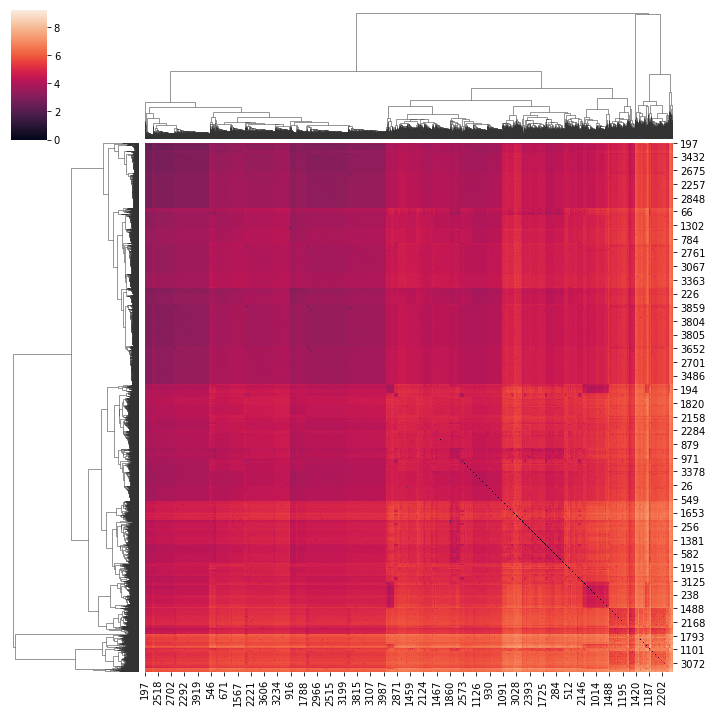

In [0]:
# Euclidean Heatmap
heat_map = sb.clustermap(euclidean_matrix)
plt.show()
# plt.savefig('Euclidean Heatmap.png')
# plt.close()


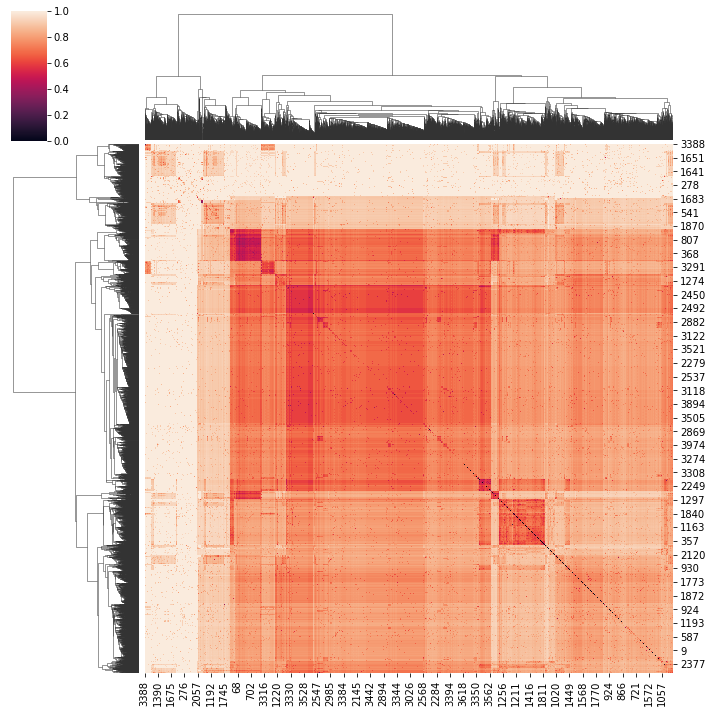

In [0]:
# Cosine Heatmap
heat_map = sb.clustermap(cosine_matrix)
plt.show()
# plt.savefig('Cosine Heatmap.png')
# plt.close()

In [24]:

def calculate_cohesion_separation(matrix, labels):
    cluster_sums = {}
    global_average = 0
    for label in np.unique(labels):
        cluster_sums[label] = 0
    for label,tweet in zip(labels,matrix):
        cluster_sums[label] += sum(tweet)
        global_average += sum(tweet)
        
    global_average = global_average / len(labels)

    cluster_averages = {}
    for label,cluster_sum in cluster_sums.items():
        cluster_averages[label] = cluster_sum / len(list(filter(lambda x: x == label, labels)))
                
    separation = calculate_separation(matrix, labels, cluster_averages, global_average)
        
    SSE = 0
    for label,tweet in zip(labels,matrix):
        SSE += (sum(tweet) - cluster_averages[label])**2
        
    return SSE, separation

def calculate_separation(matrix, labels, averages, global_average):
    
    BSS = 0
    for label,average in averages.items():
        BSS += (average - global_average)**2
                
    avg_labeled = len(labels) / len(np.unique(labels))
        
    return avg_labeled * BSS

print(calculate_cohesion_separation(cosine_matrix, cosine_clustering.labels_))
print(calculate_cohesion_separation(euclidean_matrix, euclidean_clustering.labels_))

(179224220.1506449, 240581030.95847037)
(13142168578.823431, 111413246643.12483)


In [41]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

km = MiniBatchKMeans(n_clusters=4, init='k-means++', n_init=1, init_size=1000, batch_size=1000)
labels = cosine_clustering.labels_
true_k = np.unique(labels).shape[0]
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(cosine_matrix)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


print("Top terms per cluster:")
#    if opts.n_components:
# original_space_centroids = svd.inverse_transform(km.cluster_centers_)
# order_centroids = original_space_centroids.argsort()[:, ::-1]
"""
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]
"""
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(4):
  print("Cluster %d:" % i, end='')
  for ind in order_centroids[i, :50]:
    print(' %s' % terms[ind], end='')
  print()


Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)
done in 1.242s

Homogeneity: 0.418
Completeness: 0.218
V-measure: 0.287
Adjusted Rand-Index: 0.249
Silhouette Coefficient: 0.024

Top terms per cluster:
Cluster 0: cn b6s 1vpna5v brittany alcoholics alcoholism bl1vk2 agonizing anvmxcg 1akuhmy 1ewi8h affect advice 68 assistant coffee blnimpuiuaicwuo 1ternf6 blackgirlscode 1ahvhnw 255 7tkogvh 1ahuri7 1tiefqz bariatric 200 1avejlb 1ayeoum ago ajayp41 1sptirs bl1gue bloggers 1pwm9if 1awzgdx 822 1ao5cwl central 7ojalrt 1b132on 1t1vwkr 1skdy5l 1t2eo51 7m6cgyj 1apz31w 850 1amg9gu 1aqkpco akf8bf 1axgow7
Cluster 1: bovpcji dress dragging boobs cfquhp3 aanpublic bored contacts cereal borne 120 cells cookie 5sdvvtu director chair cdctobaccofree cjcoleman22 bowl c